Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Database contains 411 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Database contains 367 images
Loading database at ../navbench/datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...
Database contains 402 images
Route length: 59.6102 m
Num training images: 411 + 367 = 778
Num test images: 402
Test time for perfect memory: 14.1514 ms
Test time for Infomax: 8.5879 ms


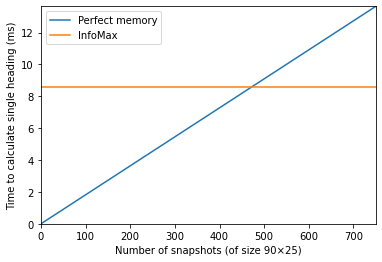

In [21]:
import sys

# Navbench commit: 8efc5721904626b678df66a54e9194005b17cf65
NAVBENCH_PATH = '../navbench'
sys.path.append(NAVBENCH_PATH)

import os
import matplotlib.pyplot as plt
import navbench as nb
import json

DB_ROOT = os.path.join(NAVBENCH_PATH, "datasets/rc_car/Stanmer_park_dataset")

def read_json(filepath):
    file = open(filepath, "r")
    data = json.load(file)["data"]["experiments"]
    file.close()
    return data

def load_databases(routes):
    return [nb.Database(os.path.join(DB_ROOT, route)) for route in routes[0]]

data_pm = read_json("benchmark_pm.json")[0]
im_size = data_pm["image_size"]
pm_test_time = data_pm["testing"]["time_per_image_ms"]

train_dbs = load_databases(data_pm["training"]["routes"])
test_dbs = load_databases(data_pm["testing"]["routes"])


num_snapshots = 0
for db in train_dbs:
    num_snapshots += len(db)
# pm_op_time = pm_test_time / (im_size[0] * im_size[1] * num_snapshots)
pm_test_time_per_snap = pm_test_time / num_snapshots

data_infomax = read_json("benchmark_infomax.json")[0]
infomax_test_time = data_infomax["testing"]["time_per_image_ms"]
# infomax_op_time = infomax_test_time / ((im_size[0] * im_size[1]) ** 2)

fig, ax = plt.subplots()
x = range(751)
ax.plot(x, [val * pm_test_time_per_snap for val in x])
ax.plot(x, len(x) * [infomax_test_time])
ax.autoscale(tight=True)
ax.set_xlabel('Number of snapshots (of size %i×%i)' % (im_size[0], im_size[1]))
ax.set_ylabel('Time to calculate single heading (ms)')
ax.legend(['Perfect memory', 'InfoMax'])

print('Route length: %g m' % (train_dbs[0].distance[-1]))
print('Num training images: %d + %d = %d' % (len(train_dbs[0]), len(train_dbs[1]), len(train_dbs[0]) + len(train_dbs[1])))
print('Num test images: %d' % len(test_dbs[0]))
print('Test time for perfect memory: %g ms' % pm_test_time)
print('Test time for Infomax: %g ms' % infomax_test_time)

fig.savefig('figures/pm_infomax_performance.svg')

Perfect memory: Mean error: 19.3511°
Infomax: Mean error: 21.3627°


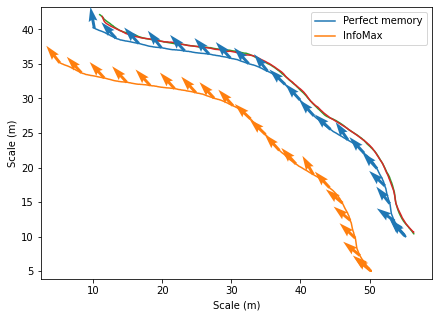

In [22]:
import math
import numpy as np

STEP = 20
LINE_OFFSET = 5

# Shift all points so the axes start at (0, 0)
allpos = np.empty((0, 2))
for db in [*train_dbs, *test_dbs]:
    allpos = np.concatenate((allpos, db.position[:, 0:2]))
minvals = np.min(allpos, axis=0) - LINE_OFFSET

heading_offset = test_dbs[0].calculate_heading_offset(0.25)
def fix_headings(headings):
    return heading_offset + np.radians(headings[0])

def get_angular_errors(test_pos, test_headings):
    ref_db = train_dbs[0]
    ref_heads = np.arctan2(np.diff(ref_db.y), np.diff(ref_db.x))
    ref_heads = np.append(ref_heads, ref_heads[-1])
    errs = []
    for row in range(test_pos.shape[0]):
        distances = [np.linalg.norm(ref_db.position[entry, 0:2] - test_pos[row, 0:2]) for entry in range(len(ref_db))]
        nearest_entry = np.argmin(distances)
        ang_dist = circ_distance(test_headings[row], ref_heads[nearest_entry])
        errs.append(abs(ang_dist))
    return np.array(errs)

assert len(test_dbs) == 1
def plot_headings(ax, data, offset=0):
    line = ax.plot(test_dbs[0].x - minvals[0] + offset, test_dbs[0].y - minvals[1] + offset)

    headings = fix_headings(data["testing"]["headings_deg"])

    u = np.cos(headings[::STEP])
    v = np.sin(headings[::STEP])
    ax.quiver(test_dbs[0].x[::STEP]-minvals[0]+offset, test_dbs[0].y[::STEP]-minvals[1]+offset, u, v, angles='xy', color=line[0].get_color(), zorder=5)
    return headings

def circ_distance(x, y):
    r = (y - x) % math.tau
    while (r > math.pi):
        r -= math.tau
    return r

def print_err(label, data, headings):
    headings = fix_headings(data["testing"]["headings_deg"])
    errs = get_angular_errors(test_dbs[0].position[:, 0:2],headings)
    print('%s: Mean error: %g°' % (label, math.degrees(np.mean(errs))))

fig, ax = plt.subplots(figsize=(7, 5))
headings_pm = plot_headings(ax, data_pm, offset=LINE_OFFSET)
headings_infomax = plot_headings(ax, data_infomax)
print_err('Perfect memory', data_pm, headings_pm)
print_err('Infomax', data_infomax, headings_infomax)

for db in train_dbs:
    ax.plot(db.x - minvals[0] + LINE_OFFSET, db.y - minvals[1] + LINE_OFFSET)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.axis('equal')
ax.set_xlabel('Scale (m)')
ax.set_ylabel('Scale (m)')
ax.legend(['Perfect memory', 'InfoMax']);

fig.savefig('figures/pm_infomax_quiver.svg', bbox_inches='tight')

Mean errors for perfect memory: 19.3511 (+-13.1998) deg
Errors over 30°: 28.1095%
Mean errors for InfoMax: 21.3627 (+-13.3506) deg
Errors over 30°: 34.0796%


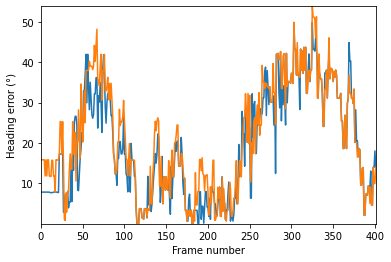

In [23]:
import math

ERROR_THRESH_DEG = 30

test_pos = test_dbs[0].position

def print_info(label, errs):
    mean = math.degrees(np.mean(errs))
    std = math.degrees(np.std(errs))
    print('Mean errors for %s: %g (+-%g) deg' % (label, mean, std))
    prop = np.mean(errs > math.radians(ERROR_THRESH_DEG))
    print('Errors over %g°: %g%%' % (ERROR_THRESH_DEG, 100 * prop))

errs_pm = get_angular_errors(test_pos, headings_pm)
errs_infomax = get_angular_errors(test_pos, headings_infomax)

print_info('perfect memory', errs_pm)
print_info('InfoMax', errs_infomax)

_, ax = plt.subplots()
ax.plot(np.degrees(errs_pm))
ax.plot(np.degrees(errs_infomax))
ax.set_ylabel('Heading error (°)')
ax.set_xlabel('Frame number')
ax.autoscale(tight=True)

In [25]:
data_perf = read_json('benchmark_perf_vs_num_snaps.json')[0]

err_fun = lambda errs: math.degrees(np.mean(errs))
# err_fun = lambda errs: np.mean(errs > math.radians(20))

_, ax = plt.subplots()
score = dict()
for algo in ['perfect_memory', 'infomax']:
    score[algo] = { 'time': [], 'error': []}
    for test_data in data_perf['testing'][algo]:
        score[algo]['time'].append(test_data['time_per_image_ms'])

        test_pos = test_dbs[0].position[::test_data['step'], :]
        headings = fix_headings(test_data['headings_deg'])
        errs = get_angular_errors(test_pos, headings)
        score[algo]['error'].append(err_fun(errs))

    ax.scatter(score[algo]['time'], score[algo]['error'])

ax.set_xlabel('Time to calculate single heading (ms)')
ax.set_ylabel('Mean navigation error (°)');

TypeError: string indices must be integers

In [ ]:
data_infomax_multi = read_json('benchmark_infomax_multi.json')
